# Vision Transformer (ViT) Backbone with PyTorch

This notebook demonstrates how to use a pre-trained Vision Transformer (ViT) from torchvision as a backbone for multi-task learning on the UTKFace dataset.

## Resource Management (4GB RAM)
Set PyTorch and DataLoader options to avoid OOM errors on a 4GB RAM system.

In [7]:
import torch
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"  # Helps avoid CUDA fragmentation OOM
# Tip: Lower batch size further if you still get OOM (try 4 or 2)
# You can also call torch.cuda.empty_cache() after each epoch if needed
# Consider torch.cuda.amp for mixed precision if supported
# Limit number of CPU threads
torch.set_num_threads(2)
os.environ['OMP_NUM_THREADS'] = '2'
# Reduce DataLoader workers and batch size if needed
BATCH_SIZE = 4  # Lowered for 4GB RAM
NUM_WORKERS = 0  # Set to 0 to avoid multiprocessing overhead on low RAM

## 1. Setup and Imports

Import the required libraries.

In [8]:
import torch
from torchvision.models import vit_b_16

## 2. Load Pre-trained ViT Model

Load a pre-trained ViT model as a backbone. You can use `weights="IMAGENET1K_V1"` for ImageNet pre-trained weights or `weights=None` for random initialization.

In [9]:
# Load a pre-trained ViT model
model = vit_b_16(weights="IMAGENET1K_V1")  # or weights=None for random init
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

## 3. Load and Explore Dataset

The UTKFace dataset contains face images labeled with age, gender, and race. The filenames are in the format `[age]_[gender]_[race]_[date&time].jpg`. Let's load the dataset and explore its structure.

In [10]:
import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

DATASET_PATH = './UTKFaceClean'
IMG_SIZE = 224
BATCH_SIZE = 32

def extract_info_from_filename(filepath):
    filename = os.path.basename(filepath)
    parts = filename.split('_', 3)
    if len(parts) < 4:
        return None  # Mark as invalid
    age, gender, race, _ = parts
    return {
        'filepath': filepath,
        'age': int(age),
        'gender': int(gender),
        'race': int(race)
    }

image_paths = glob(os.path.join(DATASET_PATH, '*.jpg'))
print(f'Total images found: {len(image_paths)}')
data = []
skipped = 0
for path in image_paths:
    info = extract_info_from_filename(path)
    if info is not None:
        data.append(info)
    else:
        skipped += 1
if skipped > 0:
    print(f"Skipped {skipped} files due to missing values in filename.")
df = pd.DataFrame(data)
print(df.head())

Total images found: 23704
                                       filepath  age  gender  race
0  ./UTKFaceClean/100_0_0_20170112213500903.jpg  100       0     0
1  ./UTKFaceClean/100_0_0_20170112215240346.jpg  100       0     0
2  ./UTKFaceClean/100_1_0_20170110183726390.jpg  100       1     0
3  ./UTKFaceClean/100_1_0_20170112213001988.jpg  100       1     0
4  ./UTKFaceClean/100_1_0_20170112213303693.jpg  100       1     0


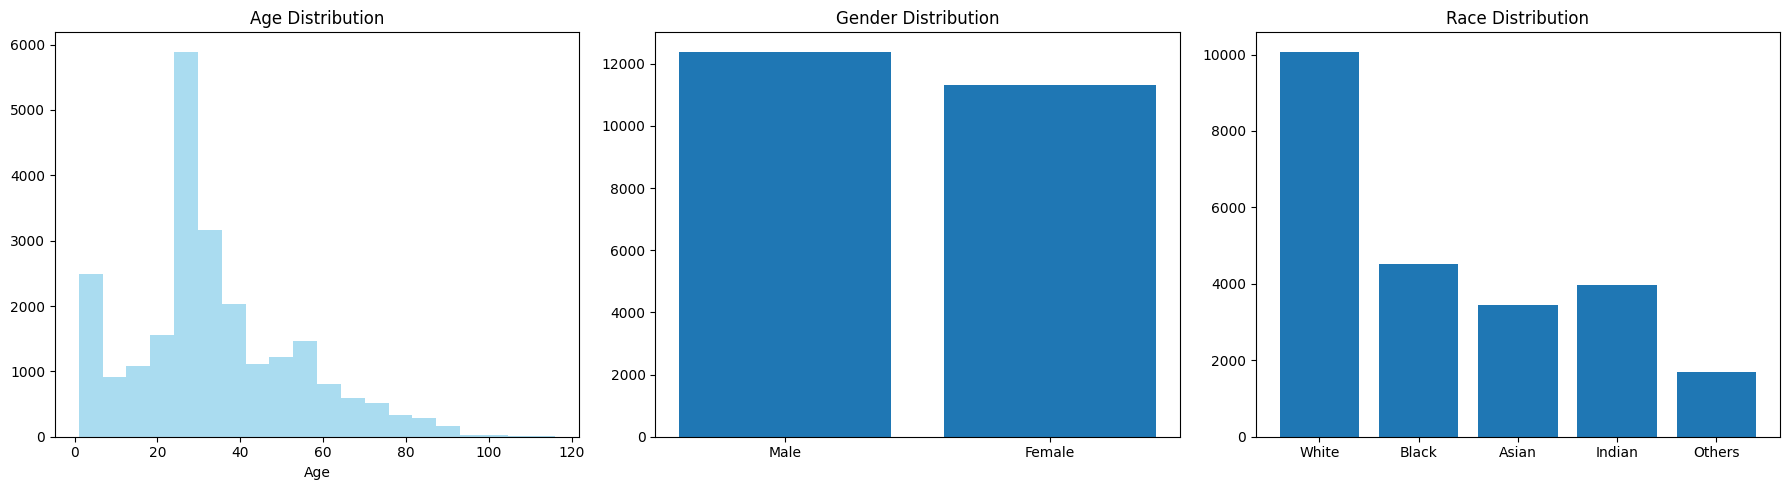

In [11]:
# Visualize label distributions
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.hist(df['age'], bins=20, alpha=0.7, color='skyblue')
plt.xlabel('Age')
plt.title('Age Distribution')
plt.subplot(1, 3, 2)
plt.bar(['Male', 'Female'], df['gender'].value_counts().sort_index())
plt.title('Gender Distribution')
plt.subplot(1, 3, 3)
plt.bar(['White', 'Black', 'Asian', 'Indian', 'Others'], df['race'].value_counts().sort_index())
plt.title('Race Distribution')
plt.tight_layout()
plt.show()

## 4. Balance Dataset

Balance the dataset to ensure equal representation across gender and race categories.

In [12]:
def balance_dataset(df):
    grouped = df.groupby(['gender', 'race'])
    n_samples = grouped.size().min()
    balanced = grouped.apply(lambda x: x.sample(n_samples, random_state=42)).reset_index(drop=True)
    return balanced

df_balanced = balance_dataset(df)
print(df_balanced.groupby(['gender', 'race']).size())

gender  race
0       0       760
        1       760
        2       760
        3       760
        4       760
1       0       760
        1       760
        2       760
        3       760
        4       760
dtype: int64


/tmp/ipykernel_46680/3299581645.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced = grouped.apply(lambda x: x.sample(n_samples, random_state=42)).reset_index(drop=True)


## 5. Prepare PyTorch Dataset and DataLoader

Split the data and create PyTorch datasets and dataloaders.

In [13]:
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

train_df, test_df = train_test_split(df_balanced, test_size=0.2, random_state=42, stratify=df_balanced[['gender', 'race']])
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42, stratify=train_df[['gender', 'race']])

class UTKFaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['filepath']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        age = torch.tensor(row['age'], dtype=torch.float32)
        gender = torch.tensor(row['gender'], dtype=torch.long)
        race = torch.tensor(row['race'], dtype=torch.long)
        return image, {'age': age, 'gender': gender, 'race': race}

In [ ]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
train_dataset = UTKFaceDataset(train_df, transform=transform)
val_dataset = UTKFaceDataset(val_df, transform=transform)
test_dataset = UTKFaceDataset(test_df, transform=transform)
# Improved DataLoader settings for speed and GPU efficiency
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)

## 6. Define Multi-Task Model

Use ViT as a backbone and add heads for age (regression), gender (binary), and race (multi-class).

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class MultiTaskViT(nn.Module):
    def __init__(self, backbone, num_races=5):
        super().__init__()
        self.backbone = backbone
        self.backbone.heads = nn.Identity()  # Remove classification head
        hidden_dim = self.backbone.hidden_dim
        self.age_head = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )
        self.gender_head = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )
        self.race_head = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_races)
        )
    def forward(self, x):
        feats = self.backbone(x)
        age = self.age_head(feats)
        gender = self.gender_head(feats)
        race = self.race_head(feats)
        return age.squeeze(1), gender.squeeze(1), race

In [ ]:
model = MultiTaskViT(vit_b_16(weights="IMAGENET1K_V1"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


MultiTaskViT(
  (backbone): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1):

## 7. Training Loop

Train the model with appropriate loss functions for each task.

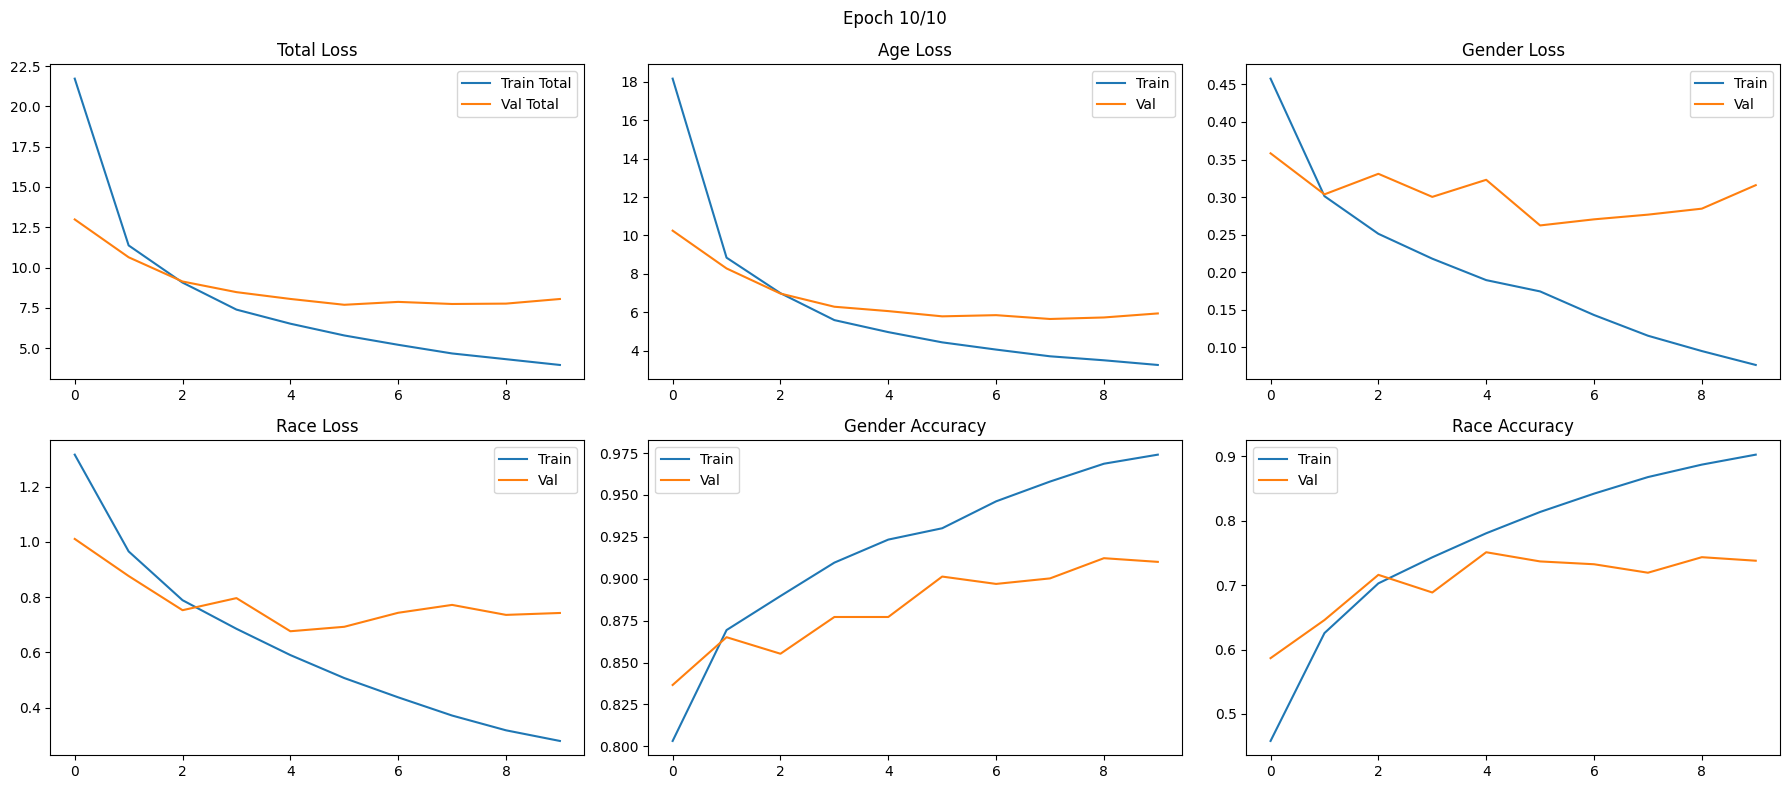

Epoch 10/10 | Train Loss: 3.9612 | Val Loss: 8.0526
  Age Loss: 3.2504 (train), 5.9361 (val)
  Gender Loss: 0.0763 (train), 0.3158 (val) | Acc: 0.9741 (train), 0.9101 (val)
  Race Loss: 0.2791 (train), 0.7424 (val) | Acc: 0.9027 (train), 0.7379 (val)


In [ ]:
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
optimizer = optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 100  # High epoch for final model
train_losses, val_losses = [], []
import matplotlib.pyplot as plt
from IPython.display import clear_output
# Initialize lists to store per-head metrics
train_age_losses, train_gender_losses, train_race_losses = [], [], []
val_age_losses, val_gender_losses, val_race_losses = [], [], []
train_gender_accs, train_race_accs = [], []
val_gender_accs, val_race_accs = [], []
# --- Early Stopping Utility ---
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
    def __call__(self, val_loss, model):
        if self.best_score is None or val_loss < self.best_score - self.min_delta:
            self.best_score = val_loss
            self.counter = 0
            self.best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
early_stopper = EarlyStopping(patience=10)
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    age_loss_sum, gender_loss_sum, race_loss_sum = 0.0, 0.0, 0.0
    gender_correct, race_correct, total = 0, 0, 0
    for images, targets in tqdm(train_loader):
        images = images.to(device)
        age = targets['age'].to(device)
        gender = targets['gender'].to(device)
        race = targets['race'].to(device)
        optimizer.zero_grad()
        if scaler is not None:
            with torch.cuda.amp.autocast():
                age_pred, gender_pred, race_pred = model(images)
                loss, age_l, gender_l, race_l = multitask_loss(age_pred, age, gender_pred, gender, race_pred, race)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            age_pred, gender_pred, race_pred = model(images)
            loss, age_l, gender_l, race_l = multitask_loss(age_pred, age, gender_pred, gender, race_pred, race)
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * images.size(0)
        age_loss_sum += age_l.item() * images.size(0)
        gender_loss_sum += gender_l.item() * images.size(0)
        race_loss_sum += race_l.item() * images.size(0)
        # Accuracy for gender and race
        gender_correct += ((torch.sigmoid(gender_pred) > 0.5).long() == gender).sum().item()
        race_correct += (torch.argmax(race_pred, dim=1) == race).sum().item()
        total += images.size(0)
    train_losses.append(running_loss / len(train_loader.dataset))
    train_age_losses.append(age_loss_sum / len(train_loader.dataset))
    train_gender_losses.append(gender_loss_sum / len(train_loader.dataset))
    train_race_losses.append(race_loss_sum / len(train_loader.dataset))
    train_gender_accs.append(gender_correct / total)
    train_race_accs.append(race_correct / total)
    # Validation
    model.eval()
    val_loss = 0.0
    val_age_loss, val_gender_loss, val_race_loss = 0.0, 0.0, 0.0
    val_gender_correct, val_race_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            age = targets['age'].to(device)
            gender = targets['gender'].to(device)
            race = targets['race'].to(device)
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    age_pred, gender_pred, race_pred = model(images)
                    loss, age_l, gender_l, race_l = multitask_loss(age_pred, age, gender_pred, gender, race_pred, race)
            else:
                age_pred, gender_pred, race_pred = model(images)
                loss, age_l, gender_l, race_l = multitask_loss(age_pred, age, gender_pred, gender, race_pred, race)
            val_loss += loss.item() * images.size(0)
            val_age_loss += age_l.item() * images.size(0)
            val_gender_loss += gender_l.item() * images.size(0)
            val_race_loss += race_l.item() * images.size(0)
            val_gender_correct += ((torch.sigmoid(gender_pred) > 0.5).long() == gender).sum().item()
            val_race_correct += (torch.argmax(race_pred, dim=1) == race).sum().item()
            val_total += images.size(0)
    val_losses.append(val_loss / len(val_loader.dataset))
    val_age_losses.append(val_age_loss / len(val_loader.dataset))
    val_gender_losses.append(val_gender_loss / len(val_loader.dataset))
    val_race_losses.append(val_race_loss / len(val_loader.dataset))
    val_gender_accs.append(val_gender_correct / val_total)
    val_race_accs.append(val_race_correct / val_total)
    # Calculate MAE for age prediction
    train_age_mae = mean_absolute_error([a.item() for images, targets in train_loader for a in targets['age']], [a for images, targets in train_loader for a in model(images.to(device))[0].detach().cpu().numpy()])
    val_age_mae = mean_absolute_error([a.item() for images, targets in val_loader for a in targets['age']], [a for images, targets in val_loader for a in model(images.to(device))[0].detach().cpu().numpy()])
    # Live plot
    clear_output(wait=True)
    fig, axs = plt.subplots(2, 3, figsize=(18, 8))
    axs[0, 0].plot(train_losses, label='Train Total'); axs[0, 0].plot(val_losses, label='Val Total'); axs[0, 0].set_title('Total Loss'); axs[0, 0].legend()
    axs[0, 1].plot(train_age_losses, label='Train'); axs[0, 1].plot(val_age_losses, label='Val'); axs[0, 1].set_title('Age Loss'); axs[0, 1].legend()
    axs[0, 2].plot(train_gender_losses, label='Train'); axs[0, 2].plot(val_gender_losses, label='Val'); axs[0, 2].set_title('Gender Loss'); axs[0, 2].legend()
    axs[1, 0].plot(train_race_losses, label='Train'); axs[1, 0].plot(val_race_losses, label='Val'); axs[1, 0].set_title('Race Loss'); axs[1, 0].legend()
    axs[1, 1].plot(train_gender_accs, label='Train'); axs[1, 1].plot(val_gender_accs, label='Val'); axs[1, 1].set_title('Gender Accuracy'); axs[1, 1].legend()
    axs[1, 2].plot(train_race_accs, label='Train'); axs[1, 2].plot(val_race_accs, label='Val'); axs[1, 2].set_title('Race Accuracy'); axs[1, 2].legend()
    plt.suptitle(f'Epoch {epoch+1}/{EPOCHS}')
    plt.tight_layout()
    plt.show()
    print(f'Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}')
    print(f'  Age Loss: {train_age_losses[-1]:.4f} (train), {val_age_losses[-1]:.4f} (val)')
    print(f'  Gender Loss: {train_gender_losses[-1]:.4f} (train), {val_gender_losses[-1]:.4f} (val) | Acc: {train_gender_accs[-1]:.4f} (train), {val_gender_accs[-1]:.4f} (val)')
    print(f'  Race Loss: {train_race_losses[-1]:.4f} (train), {val_race_losses[-1]:.4f} (val) | Acc: {train_race_accs[-1]:.4f} (train), {val_race_accs[-1]:.4f} (val)')
    print(f'  Age MAE: {train_age_mae:.2f} (train), {val_age_mae:.2f} (val)')
    early_stopper(val_losses[-1], model)
    if early_stopper.early_stop:
        print("Early stopping triggered! Restoring best model.")
        model.load_state_dict(early_stopper.best_state)
        break

## 8. Evaluation

Evaluate the model on the test set and print metrics for each task.

In [20]:
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, confusion_matrix
model.eval()
age_true, age_pred_list = [], []
gender_true, gender_pred_list = [], []
race_true, race_pred_list = [], []
with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)
        age = targets['age'].cpu().numpy()
        gender = targets['gender'].cpu().numpy()
        race = targets['race'].cpu().numpy()
        a_pred, g_pred, r_pred = model(images)
        age_true.extend(age)
        age_pred_list.extend(a_pred.cpu().numpy())
        gender_true.extend(gender)
        gender_pred_list.extend((torch.sigmoid(g_pred) > 0.5).cpu().numpy().astype(int))
        race_true.extend(race)
        race_pred_list.extend(torch.argmax(r_pred, dim=1).cpu().numpy())
print('Age MAE:', mean_absolute_error(age_true, age_pred_list))
print('Gender Accuracy:', accuracy_score(gender_true, gender_pred_list))
print('Race Accuracy:', accuracy_score(race_true, race_pred_list))
print('Gender Classification Report:', 
      classification_report(gender_true, gender_pred_list, target_names=['Male', 'Female']))
print('Race Classification Report:', 
      classification_report(race_true, race_pred_list, target_names=['White', 'Black', 'Asian', 'Indian', 'Others']))

Age MAE: 5.398123114791356
Gender Accuracy: 0.8986842105263158
Race Accuracy: 0.7625
Gender Classification Report:               precision    recall  f1-score   support

        Male       0.93      0.87      0.90       760
      Female       0.88      0.93      0.90       760

    accuracy                           0.90      1520
   macro avg       0.90      0.90      0.90      1520
weighted avg       0.90      0.90      0.90      1520

Race Classification Report:               precision    recall  f1-score   support

       White       0.81      0.66      0.73       304
       Black       0.91      0.85      0.88       304
       Asian       0.87      0.91      0.89       304
      Indian       0.72      0.77      0.75       304
      Others       0.55      0.62      0.58       304

    accuracy                           0.76      1520
   macro avg       0.77      0.76      0.76      1520
weighted avg       0.77      0.76      0.76      1520



## 9. Visualize Results

Plot training/validation loss and show some predictions.

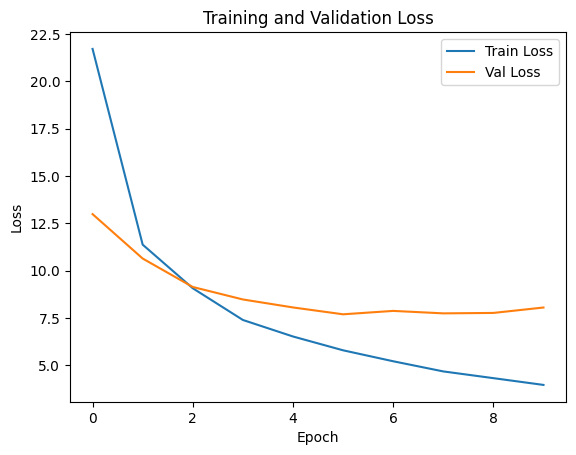

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 3.80 GiB of which 3.81 MiB is free. Including non-PyTorch memory, this process has 3.79 GiB memory in use. Of the allocated memory 3.45 GiB is allocated by PyTorch, and 242.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

<Figure size 1500x800 with 0 Axes>

In [23]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
# Show predictions on a few test images
import numpy as np
n_show = 9
shown = 0
plt.figure(figsize=(15, 8))
for images, targets in test_loader:
    images = images.to(device)
    a_pred, g_pred, r_pred = model(images)
    batch_size = images.size(0)
    for i in range(batch_size):
        if shown >= n_show:
            break
        img = images[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
        true_age = int(targets['age'][i])
        true_gender = int(targets['gender'][i])
        true_race = int(targets['race'][i])
        pred_age = int(a_pred[i].cpu().item())
        pred_gender = int((torch.sigmoid(g_pred[i])>0.5).cpu().item())
        pred_race = int(torch.argmax(r_pred[i]).cpu().item())
        plt.subplot(3, 3, shown+1)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(f'True: Age={true_age}, Gender={true_gender}, Race={true_race}\nPred: Age={pred_age}, Gender={pred_gender}, Race={pred_race}')
        plt.axis('off')
        print(f'Image {shown+1}: True -> Age: {true_age}, Gender: {true_gender}, Race: {true_race} | Pred -> Age: {pred_age}, Gender: {pred_gender}, Race: {pred_race}')
        shown += 1
    if shown >= n_show:
        break
plt.tight_layout()
plt.show()

## 10. Save the Model

Save the trained model for future use.

In [22]:
torch.save(model.state_dict(), './vit_multitask_model.pth')
print('Model saved to ./vit_multitask_model.pth')

Model saved to ./vit_multitask_model.pth


In [ ]:
# --- Fine-tuning: Unfreeze ViT Backbone ---
# After initial training and early stopping, unfreeze the backbone for fine-tuning
for param in model.backbone.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=1e-5)  # Lower LR for fine-tuning
print("Backbone unfrozen. Ready for fine-tuning with a lower learning rate.")
# You can now re-run the training loop above for a few more epochs to fine-tune

# Define multitask_loss function
def multitask_loss(age_pred, age_true, gender_pred, gender_true, race_pred, race_true):
    # Define loss functions for each task
    age_loss_fn = nn.MSELoss()  # Mean Squared Error for regression
    gender_loss_fn = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy for binary classification
    race_loss_fn = nn.CrossEntropyLoss()  # Cross-Entropy for multi-class classification

    # Calculate individual losses
    age_loss = age_loss_fn(age_pred, age_true)
    gender_loss = gender_loss_fn(gender_pred, gender_true.float())  # Ensure gender_true is float for BCEWithLogitsLoss
    race_loss = race_loss_fn(race_pred, race_true)

    # Combine losses with weights (you can adjust weights as needed)
    total_loss = age_loss + gender_loss + race_loss
    return total_loss, age_loss, gender_loss, race_loss

# --- Fine-tuning: Unfreeze ViT Backbone and Train Further ---
# Unfreeze the backbone
for param in model.backbone.parameters():
    param.requires_grad = True
# Use a lower learning rate for fine-tuning
optimizer = optim.Adam(model.parameters(), lr=1e-5)
print("Backbone unfrozen. Starting fine-tuning...")
FINE_TUNE_EPOCHS = 5  # You can increase for more fine-tuning
for epoch in range(FINE_TUNE_EPOCHS):
    model.train()
    running_loss = 0.0
    for images, targets in tqdm(train_loader):
        images = images.to(device)
        age = targets['age'].to(device)
        gender = targets['gender'].to(device)
        race = targets['race'].to(device)
        optimizer.zero_grad()
        if scaler is not None:
            with torch.cuda.amp.autocast():
                age_pred, gender_pred, race_pred = model(images)
                loss, _, _, _ = multitask_loss(age_pred, age, gender_pred, gender, race_pred, race)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            age_pred, gender_pred, race_pred = model(images)
            loss, _, _, _ = multitask_loss(age_pred, age, gender_pred, gender, race_pred, race)
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * images.size(0)
    print(f"Fine-tune Epoch {epoch+1}/{FINE_TUNE_EPOCHS} | Train Loss: {running_loss / len(train_loader.dataset):.4f}")